In [1]:
# Setup library
## install -r requirements.txt
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import matplotlib.pylab as plt
# %matplotlib widget
%matplotlib inline
import PIL.Image as Image
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [2]:
IMG_DATA = './data'
IMG_SHAPE = (224, 224)

In [3]:
# Classifier from TF hub
classifier_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2' #@param {type:"string"}
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMG_SHAPE+(3, )) # Channel 3 RGB
])

## And labels
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 
                                      'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [74]:
# prepare dataset
dataset_root = os.path.abspath(os.path.expanduser(IMG_DATA))
print(f'Dataset root: {dataset_root}')

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                  validation_split=0.1)
train_data = image_generator.flow_from_directory(dataset_root, target_size=IMG_SHAPE,
                                                 subset='training')
validation_data = image_generator.flow_from_directory(dataset_root, target_size=IMG_SHAPE,
                                                      shuffle=False,
                                                 subset='validation')

for image_batch, label_batch in validation_data:
    print(f'Image batch shape: {image_batch.shape}')
    print(f'Label batch shape: {label_batch.shape}')
    break

Dataset root: /home/harny/Github/cell-classification/data
Found 842 images belonging to 3 classes.
Found 92 images belonging to 3 classes.
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 3)


Batch result shape: (32, 1001)
Batch predicted class names: ['nematode' 'bubble' 'bubble' 'chain mail' 'brain coral' 'nematode'
 'brain coral' 'nematode' 'nematode' 'nematode' 'bubble' 'bubble' 'stole'
 'jellyfish' 'bubble' 'nematode' 'nematode' 'nematode' 'wine bottle'
 'nematode' 'bubble' 'nematode' 'chain mail' 'nematode' 'brain coral'
 'bubble' 'bubble' 'jellyfish' 'chain mail' 'brain coral' 'paper towel'
 'bubble']


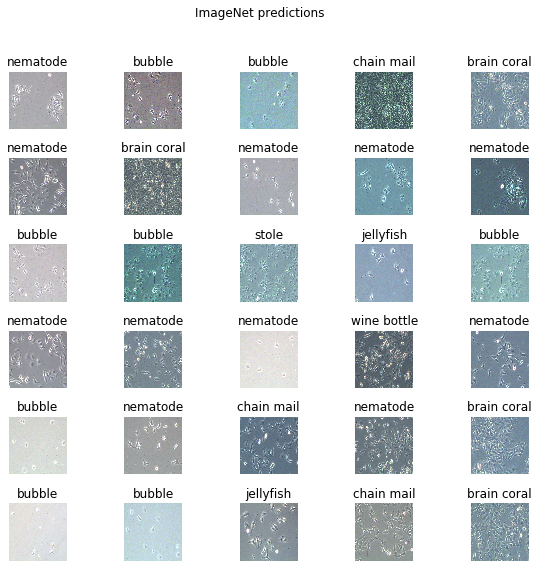

In [5]:
# Predict batch input example
## using original ImangeNet classifier
result_batch = classifier.predict(image_batch)
print(f'Batch result shape: {result_batch.shape}')

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
print(f'Batch predicted class names: {predicted_class_names}')

fig1 = plt.figure(figsize=(10, 9))
fig1.subplots_adjust(hspace=0.5)
for n in range(30):
    ax = fig1.add_subplot(6, 5, n+1)
    ax.imshow(image_batch[n])
    ax.set_title(predicted_class_names[n])
    ax.axis('off')
_ = fig1.suptitle('ImageNet predictions')

In [6]:
# Prepare transfer learning
## Download headless (without the top classification layer) model
feature_extractor_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2' #@param {type:"string"}
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMG_SHAPE+(3, ))
feature_batch = feature_extractor_layer(image_batch)
print(f'Feature vector shape: {feature_batch.shape}')

## Frozen feature extraction layer
feature_extractor_layer.trainable = False # for transfer learning classifier

## Make a model for classification
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(train_data.num_classes, activation='softmax')
])

Feature vector shape: (32, 1280)


In [7]:
## Check the model and prediction result
model.summary()

predictions = model(image_batch)
print(f'Prediction shape: {predictions.shape}')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
Prediction shape: (32, 3)


In [8]:
# Train build
## Compile model for train
base_learning_rate = 0.001 # default
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

## Log class
### https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_val_losses = []
        self.batch_acc = []
        self.batch_val_acc = []
    
    def on_epoch_end(self, epoch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
        self.batch_val_losses.append(logs['val_loss'])
        self.batch_val_acc.append(logs['val_accuracy'])
        self.model.reset_metrics()

In [9]:
steps_per_epoch = np.ceil(train_data.samples/train_data.batch_size) # train all dataset per epoch
initial_epoch = 10
batch_stats_callback = CollectBatchStats()

history = model.fit_generator(train_data,
                              epochs=initial_epoch,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=validation_data,
                              callbacks=[batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 27.0 steps, validate for 3 steps
Epoch 1/10
27/27 [==============================] - 29s 1s/step - loss: 0.9734 - accuracy: 0.5808 - val_loss: 0.8804 - val_accuracy: 0.6848
Epoch 2/10
27/27 [==============================] - 27s 996ms/step - loss: 0.7735 - accuracy: 0.8432 - val_loss: 0.7958 - val_accuracy: 0.7283
Epoch 3/10
27/27 [==============================] - 27s 1s/step - loss: 0.7103 - accuracy: 0.9026 - val_loss: 0.7285 - val_accuracy: 0.8478
Epoch 4/10
27/27 [==============================] - 27s 1s/step - loss: 0.6838 - accuracy: 0.9169 - val_loss: 0.7077 - val_accuracy: 0.8804
Epoch 5/10
27/27 [==============================] - 27s 1s/step - loss: 0.6640 - accuracy: 0.9335 - val_loss: 0.6963 - val_accuracy: 0.9022
Epoch 6/10
27/27 [==============================] - 27s 1s/step - loss: 0.6518 - accuracy: 0.9394 - val_loss: 0.6847 - val_accuracy: 0.9130
Epoch 7/10
27/27 [==============================] - 27s 1s/step - loss: 0.6443 - accuracy: 0.9430 - val_loss: 0.67

Text(0.5, 0, 'epoch')

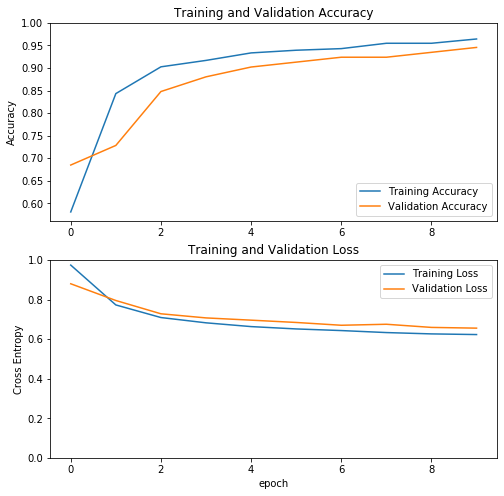

In [10]:
# Draw learning curves chart
acc = batch_stats_callback.batch_acc
val_acc = batch_stats_callback.batch_val_acc
loss = batch_stats_callback.batch_losses
val_loss = batch_stats_callback.batch_val_losses

fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(2, 1, 1)
ax1.plot(acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.legend(loc='lower right')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([min(plt.ylim()),1])
ax1.set_title('Training and Validation Accuracy')

ax2 = fig2.add_subplot(2, 1, 2)
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.legend(loc='upper right')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim([0,1.0])
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('epoch')

Classes: ['Hek293' 'Hela' 'Pc12']


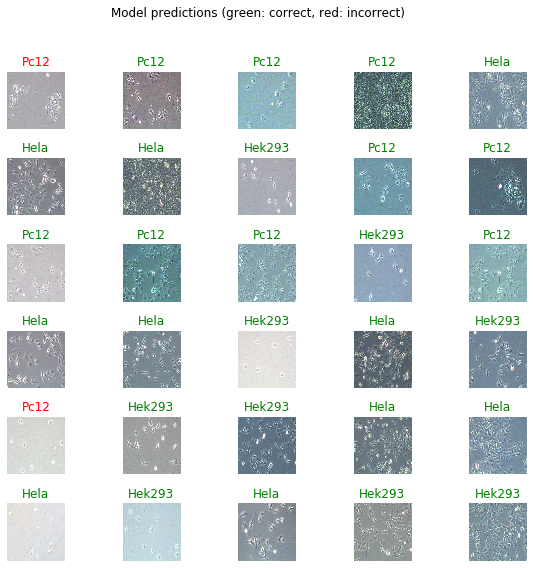

In [11]:
# Plot results
class_names = sorted(validation_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(f'Classes: {class_names}')

## get result labels
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

## plot
fig3 = plt.figure(figsize=(10,9))
fig3.subplots_adjust(hspace=0.5)
for n in range(30):
    ax = fig3.add_subplot(6, 5, n+1)
    ax.imshow(image_batch[n])
    color = 'green' if predicted_id[n] == label_id[n] else 'red'
    ax.set_title(predicted_label_batch[n].title(), color=color)
    ax.axis('off')
_ = fig3.suptitle('Model predictions (green: correct, red: incorrect)')

In [12]:
# Export model
t = time.time()

export_path = f'./saved_models/{int(t)}'
model.save(export_path, save_format='tf')

print(f'Export the model to {export_path}')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./saved_models/1582091591/assets


INFO:tensorflow:Assets written to: ./saved_models/1582091591/assets


Export the model to ./saved_models/1582091591


In [13]:
# Check the exported model
reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

print(f'Comparison between own model and exported model {abs(reloaded_result_batch - result_batch).max()}')

Comparison between own model and exported model 0.0


In [14]:
## Unfrozen feature extraction layer
feature_extractor_layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________


In [15]:
finetune_epoch = 10

history_fine = model.fit_generator(train_data,
                                   epochs=initial_epoch+finetune_epoch,
                                   initial_epoch=initial_epoch, # == history.epoch[-1]+1
                                   steps_per_epoch=steps_per_epoch,
                                   validation_data=validation_data,
                                   callbacks = [batch_stats_callback])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 27.0 steps, validate for 3 steps
Epoch 11/20
27/27 [==============================] - 65s 2s/step - loss: 0.8043 - accuracy: 0.7767 - val_loss: 0.5738 - val_accuracy: 0.8370
Epoch 12/20
27/27 [==============================] - 63s 2s/step - loss: 0.1295 - accuracy: 0.9881 - val_loss: 0.4897 - val_accuracy: 0.8696
Epoch 13/20
27/27 [==============================] - 62s 2s/step - loss: 0.0920 - accuracy: 1.0000 - val_loss: 0.4161 - val_accuracy: 0.8804
Epoch 14/20
27/27 [==============================] - 61s 2s/step - loss: 0.0869 - accuracy: 1.0000 - val_loss: 0.4070 - val_accuracy: 0.8913
Epoch 15/20
27/27 [==============================] - 61s 2s/step - loss: 0.0858 - accuracy: 1.0000 - val_loss: 0.3860 - val_accuracy: 0.9239
Epoch 16/20
27/27 [==============================] - 61s 2s/step - loss: 0.0852 - accuracy: 1.0000 - val_loss: 0.3638 - val_accuracy: 0.9239
Epoch 17/20
27/27 [==============================] - 62s 2s/step - loss: 0.0848 - accuracy: 1.0000 - val_loss: 

Text(0.5, 0, 'epoch')

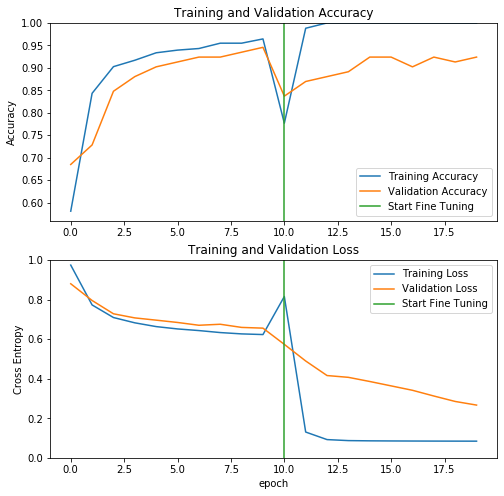

In [16]:
# Draw learning curves chart
fine_acc = batch_stats_callback.batch_acc
fine_val_acc = batch_stats_callback.batch_val_acc
fine_loss = batch_stats_callback.batch_losses
fine_val_loss = batch_stats_callback.batch_val_losses

fig4 = plt.figure(figsize=(8, 8))
ax1 = fig4.add_subplot(2, 1, 1)
ax1.plot(acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([min(plt.ylim()),1])
ax1.plot([initial_epoch,initial_epoch],
         ax1.get_ylim(), label='Start Fine Tuning')
ax1.legend(loc='lower right')
ax1.set_title('Training and Validation Accuracy')

ax2 = fig4.add_subplot(2, 1, 2)
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim([0,1.0])
ax2.plot([initial_epoch,initial_epoch],
         ax2.get_ylim(), label='Start Fine Tuning')
ax2.legend(loc='upper right')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('epoch')

Classes: ['Hek293' 'Hela' 'Pc12']


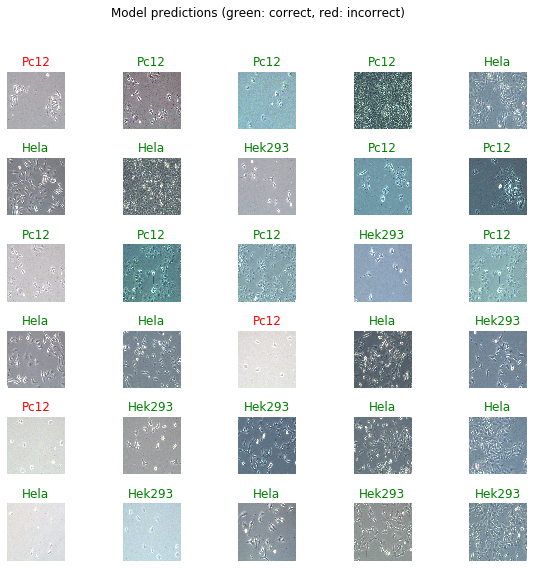

In [17]:
# Plot results
class_names = sorted(validation_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(f'Classes: {class_names}')

## get result labels
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

## plot
fig5 = plt.figure(figsize=(10,9))
fig5.subplots_adjust(hspace=0.5)
for n in range(30):
    ax = fig5.add_subplot(6, 5, n+1)
    ax.imshow(image_batch[n])
    color = 'green' if predicted_id[n] == label_id[n] else 'red'
    ax.set_title(predicted_label_batch[n].title(), color=color)
    ax.axis('off')
_ = fig5.suptitle('Model predictions (green: correct, red: incorrect)')

In [18]:
# Export model too
t = time.time()

export_path = f'./saved_models/{int(t)}'
model.save(export_path, save_format='tf')

print(f'Export the model to {export_path}')

INFO:tensorflow:Assets written to: ./saved_models/1582092227/assets


INFO:tensorflow:Assets written to: ./saved_models/1582092227/assets


Export the model to ./saved_models/1582092227


In [19]:
# Check the exported model too
reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

print(f'Comparison between own model and exported model {abs(reloaded_result_batch - result_batch).max()}')

Comparison between own model and exported model 0.0


In [90]:
# validation data classification result
validation_data.reset()

predicted_batch = model.predict(validation_data)
predicted_id = np.argmax(predicted_batch, axis=-1)

label_id = validation_data.classes

con_mat = tf.math.confusion_matrix(label_id, predicted_id)

result_df = pd.DataFrame(con_mat.numpy(), index=class_names, columns=class_names, dtype=int)

print('-- Validation result (Row: Actual Class, Column: Predicted Class) --')
print(result_df)

3/3 [==============================] - 2s 830ms/step
-- Validation result (Row: Actual Class, Column: Predicted Class) --
        Hek293  Hela  Pc12
Hek293      27     1     2
Hela         1    25     3
Pc12         0     0    33
